## Fine-tuning Audio Spectogram Transformer to GTZAN

This notebook was inspired by:
https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/audio_classification.ipynb#scrollTo=5WMEawzyCEyG

See also the original paper: https://arxiv.org/abs/2104.01778

See also Huggingface: https://huggingface.co/docs/transformers/v4.40.0/en/model_doc/audio-spectrogram-transformer#transformers.ASTConfig

In [2]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoModelForAudioClassification, TrainingArguments, Trainer
from datasets import load_metric, Dataset, load_dataset, Audio
from datasets.dataset_dict import DatasetDict
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm
import torchmetrics
import torchaudio


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import os
import re

c:\Users\ah140\OneDrive\itu\2_semester\AML\project\AML24MST\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#set up genre names and their codes
genre_names = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock",
]
genre_codes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Import these into your working script to make sure that we all have the same codes
id2label = {id_: label for id_, label in zip(genre_codes, genre_names)}
label2id = {label: id_ for label, id_ in zip(genre_names, genre_codes)}

In [4]:
SEED = 42

Load names of training/test files into lists. Make sure that you have run helper.py to create the train/test split in the folder *data_train_test/*.

In [5]:
train_files = []
test_files = []

path = './data_train_test/'
sampling_rate = 0

for set in ['train', 'test']:
    path_set = os.path.join(path, set) 
    for genre_name, genre_code in zip(genre_names, genre_codes):
        # Construct full path to genre directory
        genre_dir = os.path.join(path_set, genre_name)
        
        # Check if the directory exists
        if not os.path.isdir(genre_dir):
            print(f"Directory '{genre_dir}' does not exist.")
            continue
        
        # Loop over files in the genre directory
        for file_name in os.listdir(genre_dir):
            # Construct full path to file
            file_path = os.path.join(genre_dir, file_name)

            # Check if it's a file
            if os.path.isfile(file_path):
                wave_form = 0
                try:
                    waveform, sample_rate_file = torchaudio.load(file_path)
                    waveform_np = waveform.numpy()
                except Exception:
                    print(f'Could not load {file_name}')
                    continue
                
                if set == 'train':
                    train_files.append(file_name)
                else:
                    test_files.append(file_name)
                    
                #check that sampling rate is the same for all audio files
                if sampling_rate == 0:
                    sampling_rate = sample_rate_file
                    print(f'Sampling rate is {sampling_rate} hz')
                else:
                    if sampling_rate != sample_rate_file:
                        print("Sampling rates do not match")
            else:
                print(f"'{file_path}' is not a file.")

Sampling rate is 22050 hz


Could not load jazz.00054.wav


In [6]:
#https://huggingface.co/datasets/marsyas/gtzan
df = load_dataset("marsyas/gtzan", trust_remote_code=True)

In [7]:
def file_name_search(file_name):
    '''
    Find file-name in the path of the file. 
    '''
    match = re.search(r'(.+\\)?(.+\.wav)', file_name)
    return match.group(2)

In [8]:
df['train'][0]['file']

'C:\\Users\\ah140\\.cache\\huggingface\\datasets\\downloads\\extracted\\44f0ee4c5a621cda397ac1a241b9e21d2abba5e3afa4d534563691fe9ef1dc54\\genres\\blues\\blues.00000.wav'

In [19]:
file_name_search(df['train'][0]['file'])

'blues.00000.wav'

Now we define our train dataset by filtering only file names that occur in our list of training file names. 

We do the same for test file names.

In [80]:
df_train = df.filter(lambda x: file_name_search(x['file']) in train_files)
df_test = df.filter(lambda x: file_name_search(x['file']) in test_files)

We do a double check to see if we got the correct files.

In [66]:
train_files_ = [file_name_search(x) for x in df_train['train']['file']]
test_files_ = [file_name_search(x) for x in df_test['train']['file']]

if (train_files == train_files_) == True & (test_files == test_files_) == True:
    print('Files in df_train and df_test match the training and test files from the folder data_train_test')

Files in df_train and df_test match the training and test files from the folder data_train_test


## Feature extraction

We load the Audio Spectogram Transformer which has been pretrained on audioset. This corresponds to model 1. in the section *Pretrained Models* on the Github of the original paper.
https://github.com/YuanGongND/ast/tree/master

In [67]:
model_checkpoint = "MIT/ast-finetuned-audioset-10-10-0.4593"

We use the feature extractor from Huggingface, which extracts mel-filter bank faetures from raw speech, pads/truncates them to a fixed length, and normalises them.

In [68]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

The number of data-points in the array of the audio-files is not exactly the same. So in the feature-extractor we set max_length to 30 seconds and truncate.

The feature extractor also ensures that the sampling rate if 16.000 for all the samples.

In [69]:
sampling_rate = feature_extractor.sampling_rate
print(f'AST sampling rate: {sampling_rate} Hz')

# Resampling data
df_train = df_train.cast_column("audio", Audio(sampling_rate = 16000))
df_test = df_test.cast_column("audio", Audio(sampling_rate = 16000))

AST sampling rate: 16000 Hz


In [74]:
max_duration = 30.0 # 30 seconds

def preprocess_function(examples):
    # Extracting and saving arrays
    audio_arrays = [x['array'] for x in examples['audio']]

    # Preprocessing audio inputs
    inputs = feature_extractor(audio_arrays,
                              sampling_rate = feature_extractor.sampling_rate,
                              return_tensors="pt", # output pytorch tensors
                              max_length = int(feature_extractor.sampling_rate * max_duration),
                              truncation = True)

    return inputs

In [82]:
def apply_preprocess(df):
    df = df.map(preprocess_function,
                    remove_columns = ['audio', 'file'],
                    batched = True,
                    batch_size = 100)

    df = df.rename_column('genre', 'labels')
    return df

In [85]:
df_train = apply_preprocess(df_train)
df_test = apply_preprocess(df_test)

In [86]:
print(f"Size of spectogram, Train: {len(df_train['train'][0]['input_values'][0])}, {len(df_train['train'][0]['input_values'])}")
print(f"Size of spectogram, Test: {len(df_test['train'][0]['input_values'][0])}, {len(df_test['train'][0]['input_values'])}")

Size of spectogram, Train: 128, 1024
Size of spectogram, Test: 128, 1024


## Fine-tune

*Skip the section if you have already fine-tuned the models - Please go to inference section*

We load the pretrained AST model that we are going to fine-tune to classify music genres in GTZAN.

The output complains about mismathing sizes in the pretrained model, which was pretrained on 527 classes, and the model for GTZAN which only has 10 classes. This means that we need to fine-tune the model.

In [88]:
num_labels = len(id2label) # Obtaining the total number of labels

# Loading model
ast_model = AutoModelForAudioClassification.from_pretrained(model_checkpoint,
                                                         num_labels = num_labels,
                                                         label2id=label2id,
                                                         id2label=id2label,
                                                         ignore_mismatched_sizes=True)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We fine-tune the model using Kaggle's GPU T4 x2 for 20 epochs, which took 1 hour and 20 minutes.

In [50]:
batch_size=4 #ran out of memory with batch_size=8

training_args = TrainingArguments(
    output_dir = 'ast_gtzan',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    learning_rate = 5e-5,
    seed = SEED,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    gradient_accumulation_steps = 1,
    num_train_epochs = 1,
    warmup_ratio = 0.1,
    fp16 = True,
    save_total_limit = 2,
    report_to = 'none'
    )

In [49]:
# Loading `accuracy` metric from the evaluate library
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [33]:
trainer = Trainer(
     model=ast_model,
     args = training_args,
     train_dataset = df_train['train'],
     eval_dataset = df_test['train'],
     tokenizer = feature_extractor,
     compute_metrics = compute_metrics)

train_result = trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.588040,0.870000


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


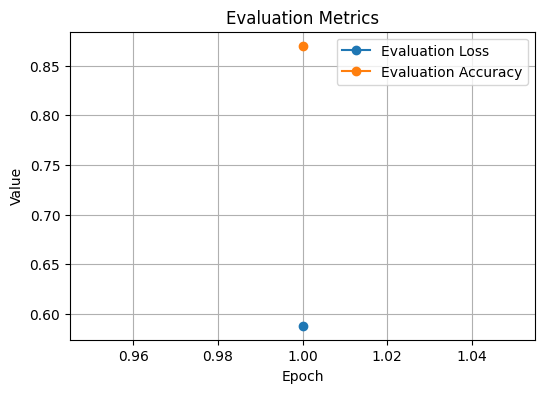

In [48]:
train_history = pd.DataFrame(trainer.state.log_history)
train_history.reset_index(inplace=True)

plt.figure(figsize=(6, 4))

# Evaluation loss plot
plt.plot(train_history['epoch'], train_history['eval_loss'], label='Evaluation Loss', marker='o')

# Evaluation accuracy plot
plt.plot(train_history['epoch'], train_history['eval_accuracy'], label='Evaluation Accuracy', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)

plt.show()

The model has an accuracy of 0.89 on the test-set.

Saves the model on kaggle.

In [62]:
save_path = 'ast_finetuned'
!mkdir {save_path}
trainer.save_model(save_path)
feature_extractor.save_pretrained(save_path)
!ls {save_path}

mkdir: cannot create directory 'ast_finetuned': File exists


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


['ast_finetuned/preprocessor_config.json']

Alternatively if you want to download the model from kaggle, please run

In [47]:
#Doanload model from Kaggle to your local pc
# from IPython.display import FileLink
# import os

# !zip -r ast_finetuned.zip {save_path}

# os.chdir(r'/kaggle/working/')
# %cd /kaggle/working
# FileLink(r'ast_finetuned.zip')

/kaggle/working


/kaggle/working/ast_finetuned.zip

## Test predictions

We start by loading the fine-tuned model.

In [64]:
num_labels = len(id2label) # Obtaining the total number of labels

# Loading model
ast_model_t = AutoModelForAudioClassification.from_pretrained('ast_finetuned',
                                                         num_labels = num_labels,
                                                         label2id=label2id,
                                                         id2label=id2label,
                                                         ignore_mismatched_sizes=True)

In [ ]:
with torch.no_grad():
    processed = ast_model_t(**test_input, output_attentions=True)

predicted_class_ids = torch.argmax(processed.logits, dim=-1).item()
predicted_label = ast_model.config.id2label[str(predicted_class_ids)]
predicted_label

In [83]:
test_input = feature_extractor(df_raw['test'][0]['audio']['array'], sampling_rate=sampling_rate, return_tensors="pt")

with torch.no_grad():
    processed = ast_model_t(**test_input, output_attentions=True)

predicted_class_ids = torch.argmax(processed.logits, dim=-1).item()
predicted_label = ast_model.config.id2label[str(predicted_class_ids)]
predicted_label

'country'

In [86]:
predictions = []

# Initialize tqdm with the total number of iterations
for i in range(df_raw['test'].num_rows):
    test_input = feature_extractor(df_raw['test'][i]['audio']['array'], sampling_rate=sampling_rate, return_tensors="pt")
    
   with torch.no_grad():
    processed = ast_model_t(**test_input, output_attentions=True)

    predicted_class_ids = torch.argmax(processed.logits, dim=-1).item()
    predicted_label = ast_model_t.config.id2label[str(predicted_class_ids)]
    predictions.append(predicted_label)

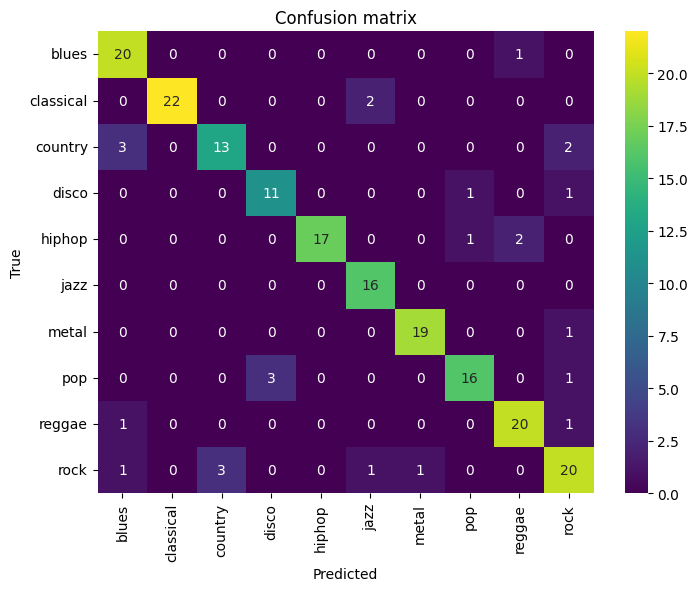

In [105]:
# Plotting the confusion matrix 

#Get true labels
true = [ast_model.config.id2label[str(x)] for x in df_raw['test']['genre']]
labels = list(ast_model_t.config.label2id.keys())

grid_cm = pd.DataFrame(confusion_matrix(true, predictions),
                       index=labels,
                       columns=labels)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix")
# Specify the colormap as 'viridis'
sn.heatmap(grid_cm, annot=True, cmap="viridis")
# Add labels to y-axis and x-axis
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## Pytorch

In [ ]:
# df.set_format("torch")

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# ast_model.to(device)

# #Set up data-loaders so we can train in batches
# train_dataloader = DataLoader(df['train'], shuffle=True, batch_size=8)
# eval_dataloader = DataLoader(df['test'], batch_size=8)

# # Setting up fine-tuning training hyperparams
# optimizer = AdamW(ast_model.parameters(), lr=5e-5) # set Adam as optimizer

# num_epochs = 20
# num_training_steps = num_epochs * len(train_dataloader)
# lr_scheduler = get_scheduler(
#     name="linear",
#     optimizer=optimizer,
#     num_warmup_steps=0,
#     num_training_steps=num_training_steps)

# #Fine-tune 
# progress_bar = tqdm(total=num_training_steps)

# ast_model.train()
# for epoch in range(num_epochs):
#     total_loss = 0.0
#     num_batches = 0

#     for batch in train_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = ast_model(**batch)
#         loss = outputs.loss
#         loss.backward()

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()

#         total_loss += loss.item()
#         num_batches += 1

#         progress_bar.update(1)

#     # Calculate average loss for the epoch
#     average_loss = total_loss / num_batches
#     print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss:.4f}")
    
# #Evaluate the accuracy
# accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_labels)

# ast_model.eval()
# for batch in eval_dataloader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     with torch.no_grad():
#         outputs = ast_model(**batch)

#     logits = outputs.logits
#     predictions = torch.argmax(logits, dim=-1)

#     # Convert predictions and references to CPU if necessary
#     predictions = predictions.cpu()
#     references = batch["labels"].cpu()

#     # Add batch to Accuracy metric
#     accuracy.update(predictions, references)

# # Compute accuracy
# accuracy_result = accuracy.compute()
# print("Accuracy:", accuracy_result.item())

# #torch.save(ast_model.state_dict(), "ast_finetuned_gtzan.pth")